In [1]:
from agent import Agent
from agent import sample_tracjectory, sample_trajectories, collect_trajectories, pathlength
import numpy as np
import gym
import torch
import matplotlib.pyplot as plt

In [2]:
#Create and train an agent.
#Returns reward for each
def train_agent(param_dict, env_name, double, n_iter):
    #Get enviorment parameters.
    env = gym.make(env_name)
    
    #get path length.
    max_path_length = env.spec.max_episode_steps or param_dict['max_path_length']
    
    #discrete
    discrete = isinstance(env.action_space, gym.spaces.Discrete)
    
    #spaces
    ob_dim = env.observation_space.shape[0]
    ac_dim = env.action_space.n if discrete else env.action_space.shape[0]
    
    #Build agent.
    policy_dict = {'ob_dim': ob_dim, 'ac_dim': ac_dim, 'discrete': discrete, 'size': param_dict['size'], 'n_layers':param_dict['n_layers'], 'learning_rate': param_dict['learning_rate']}
    sample_traj = {'animate': False, 'max_path_length': max_path_length, 'min_timesteps_per_batch': param_dict['min_timesteps_per_batch']}
    return_args = {'gamma': param_dict['gamma'], 'reward_to_go':param_dict['reward_to_go'], 'nn_baseline':param_dict['nn_baseline'], 'normalize_advantages': param_dict['normalize_advantages']}
    
    agent = Agent(policy_dict, sample_traj, return_args)
    agent.build_policy(double=double)
    
    returns = []
    ep_lengths = []
    params = []
    for itr in range(n_iter):
        #Sample Trajectories.
        paths, num_steps = sample_trajectories(agent, itr, env)
        #print(paths)
        obs_no, ac_na, params, re_n = collect_trajectories(paths)
        
        q_n, adv_n = agent.estimate_return(obs_no, re_n)
        agent.update_parameters(obs_no, ac_na, params, q_n, adv_n)
    
        #Output the final returns.
        returns = returns + [path["reward"].sum().detach().numpy() for path in paths]
        #params = params + [path["param"].detach().numpy() for path in paths]
        ep_lengths = ep_lengths + [pathlength(path) for path in paths]
        
    return agent, np.array(returns), ep_lengths, paths
        

In [3]:
param_dict = {'name':'CartPole-v0', 'n_iter':500, 'min_timesteps_per_batch':1000, 'reward_to_go':True, 'size': 64, 'n_layers':2, 'learning_rate': 5e-3, 'gamma':0.99, 'nn_baseline':False, 'normalize_advantages':True}

In [4]:
agent, returns, ep_lengths, paths = train_agent(param_dict, param_dict['name'], True, param_dict['n_iter'])

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


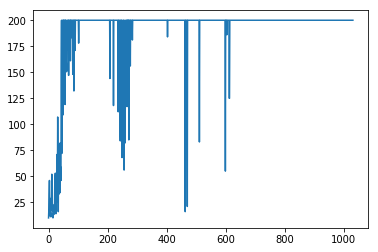

In [5]:
plt.plot(returns)